# Figures

List of figures:

* Intensity maps for 1 snapshot in time of all 6 AIA EUV channels
* Map of EM slopes
* Histogram of EM slopes with model results overlaid
* Timelag maps
* Cross-correlation maps
* Probability maps for frequency
* Frequency classification map

In [111]:
import sys
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from sunpy.map import Map
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch,LogStretch

import synthesizAR
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from formatting import get_figsize, heating_palette, qualitative_palette, timelag_cmap

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
channels = [94,131,171,193,211,335]
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [3]:
selected_channel_pairs = np.array(channel_pairs)[[0,9,12]]

In [4]:
correlation_threshold = 0.1

In [6]:
plot_opts = {'title': False, 
             'annotate': False,
             'vmin': -(5e3*u.s).to(u.s).value,
             'vmax': (5e3*u.s).to(u.s).value,
             'cmap': timelag_cmap(),
            }

## Intensities
Should we include examples of the observed AIA intensities as well?

In [48]:
m.meta['wavelnth']

335

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/storage-home/w/wtb2/anaconda3/en

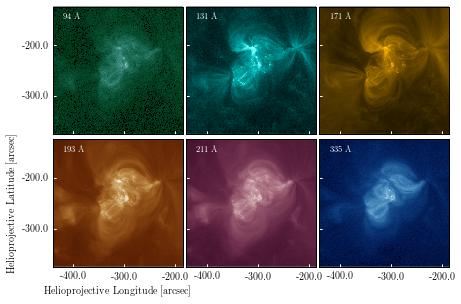

In [110]:
fig = plt.figure(figsize=get_figsize(wf=1,hf=0.68))
fits_files = [
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153502_94_cutout.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153509_131_cutout.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153500_171_cutout.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153507_193_cutout.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153500_211_cutout.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T153503_335_cutout.fits',
]
for i,f in enumerate(fits_files):
    m = Map(f)
    m = m.submap(SkyCoord(Tx=-440*u.arcsec,Ty=-380*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-185*u.arcsec,Ty=-125*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(2,3,i+1,projection=m)
    norm = ImageNormalize(vmin=0,vmax=m.data.max(),stretch=SqrtStretch())
    m.plot(axes=ax,title=False,annotate=False,norm=norm)
    ax.grid(alpha=0)
    lon,lat = ax.coords
    lon.set_ticks(color='w',number=3)
    lat.set_ticks(color='w',number=3)
    if i < 3:
        lon.set_ticklabel_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    xtext,ytext = m.world_to_pixel(SkyCoord(-420*u.arcsec, -150*u.arcsec, frame=m.coordinate_frame))
    ax.text(xtext.value,ytext.value,f'{m.meta["wavelnth"]} $\mathrm{{\AA}}$',
            color='w',fontsize=plt.rcParams['xtick.labelsize'])
    if i == 3:
        lon.set_axislabel('Helioprojective Longitude [arcsec]')
        lat.set_axislabel('Helioprojective Latitude [arcsec]')
plt.subplots_adjust(hspace=0.025,wspace=0.025)

## Timelags
Timelag maps. Histograms as well?

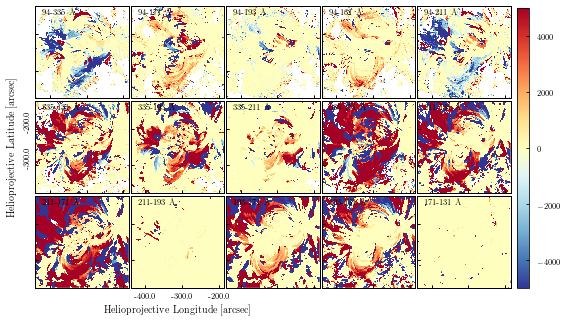

In [109]:
file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{}_{}_{}.fits'
fig = plt.figure(figsize=get_figsize(wf=1.2,hf=0.61))
cax = fig.add_axes([0.91, 0.125, 0.02, 0.75])
for i,cp in enumerate(channel_pairs):
    m = Map(file_format.format('timelag',*cp))
    mc = Map(file_format.format('correlation',*cp))
    m = Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    m = m.submap(SkyCoord(Tx=-440*u.arcsec,Ty=-380*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-185*u.arcsec,Ty=-125*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(3, 5, i+1, projection=m)
    im = m.plot(axes=ax, **plot_opts)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks(number=3)
    lat.set_ticks(number=3,) 
    if i == 5:
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'], rotation='vertical')
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
    else:
        lat.set_ticklabel_visible(False)
    if i == 11:
        lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
    else:
        lon.set_ticklabel_visible(False)
    xtext,ytext = m.world_to_pixel(SkyCoord(-420*u.arcsec, -150*u.arcsec, frame=m.coordinate_frame))
    ax.text(xtext.value,ytext.value,
            '{}-{} $\mathrm{{\AA}}$'.format(*cp),
            color='k',
            fontsize=plt.rcParams['xtick.labelsize']
           )
plt.subplots_adjust(wspace=0.02,hspace=0.02)
cbar = fig.colorbar(im, cax=cax,orientation='vertical')
#fig.savefig('../paper/figures/timelag_maps.pdf')

## Cross-correlations
cross-correlation maps. Histograms as well?

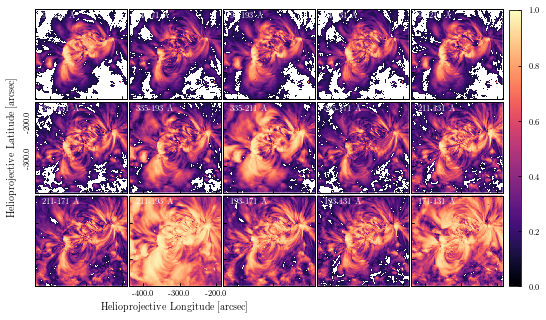

In [108]:
file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{}_{}_{}.fits'
fig = plt.figure(figsize=get_figsize(wf=1.18,hf=0.61))
cax = fig.add_axes([0.91, 0.125, 0.02, 0.75])
for i,cp in enumerate(channel_pairs):
    mc = Map(file_format.format('correlation',*cp))
    m = Map(mc.data, mc.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    m = m.submap(SkyCoord(Tx=-440*u.arcsec,Ty=-380*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-185*u.arcsec,Ty=-125*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(3, 5, i+1, projection=m)
    im = m.plot(axes=ax, **{**plot_opts, **{'vmin':0, 'vmax': 1, 'cmap': 'magma'}})
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks(number=3)
    lat.set_ticks(number=3,) 
    if i == 5:
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'], rotation='vertical')
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
    else:
        lat.set_ticklabel_visible(False)
    if i == 11:
        lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
    else:
        lon.set_ticklabel_visible(False)
    xtext,ytext = m.world_to_pixel(SkyCoord(-420*u.arcsec, -150*u.arcsec, frame=m.coordinate_frame))
    ax.text(xtext.value,ytext.value,
            '{}-{} $\mathrm{{\AA}}$'.format(*cp),
            color='w',
            fontsize=plt.rcParams['xtick.labelsize']
           )
plt.subplots_adjust(wspace=0.02,hspace=0.02)
cbar = fig.colorbar(im, cax=cax,orientation='vertical')
#fig.savefig('../paper/figures/correlation_maps.pdf')

## Emission Measure and Slopes
Compute the emission measure distribution using the method of HK12 and compute the slopes as well. Should show maps the $\mathrm{EM}(T)$ as well as the slopes

In [112]:
em = EMCube.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/dem/emcube_time_averaged.h5')

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


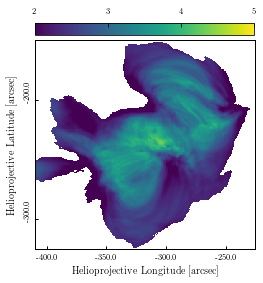

In [113]:
slope_opts = {
    'temperature_bounds': [10**(5.8),10**(6.4)]*u.K,
    'em_threshold': 1e23*u.cm**-5,
    'rsquared_tolerance': 0.9,
}
slope_map = em.make_slope_map(**slope_opts)
slope_map = slope_map.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=slope_map.coordinate_frame),
                             SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=get_figsize(wf=0.875))
cax = fig.add_axes([0.265, 0.9, 0.49, 0.04])
ax = fig.gca(projection=slope_map)
im = slope_map.plot(axes=ax,cmap='viridis',vmin=2,vmax=5,title=False,annotate=False)
ax.grid(alpha=0)
lon,lat = ax.coords
lon.set_ticks(number=4)
lat.set_ticks(number=2)
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'], rotation='vertical')
cbar = fig.colorbar(im,cax=cax, orientation='horizontal',)
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks([2,3,4,5])
lon,lat = ax.coords
lon.set_axislabel('Helioprojective Longitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel('Helioprojective Latitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev820-py3.6.egg/synthesizAR/analysis/dem.py:59: SunpyDeprecationWarning: Deprecated in favor of MapSequence.
  super().__init__(map_list)
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy-1.0.dev9846-py3.6-linux-x86_64.egg/sunpy/util/decorators.py:104: SunpyDeprecationWarning: Deprecated in favor of MapSequence. MapSequence has the same functionality as MapCube.
  return func(*args, **kwargs)


Text(0,0.5,'Number of Pixels (Normalized)')

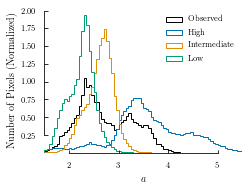

In [114]:
fig = plt.figure(figsize=get_figsize(wf=0.5,hf=0.75))
ax = fig.gca()
bins = np.arange(1,6,0.05)
bin_centers = (bins[:-1] + bins[1:])/2
opts = {'bins': bins, 'histtype': 'step','density':True, 'lw':1}
# Plot Observed EM Slopes
d = em.make_slope_map(**slope_opts).data.flatten()
h,b,_ = ax.hist(d[~np.isnan(d)],**opts,color='k',label='Observed')
# Plot Model EM Slopes
file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}_frequency/nei/dem/emcube_time_averaged.h5'
for i,h in enumerate(['high', 'intermediate', 'low']):
    slope_map = EMCube.restore(file_format.format(h)).make_slope_map(**slope_opts)
    d = slope_map.data.flatten()
    h,b,_ = ax.hist(d[~np.isnan(d)], **opts, color=heating_palette()[i], label=h.capitalize())
ax.set_xlim(1.5,5.5);
ax.set_xticks([2,3,4,5])
ax.legend(frameon=False,loc=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks()[1:-1])
ax.spines['left'].set_bounds(ax.get_yticks()[0],ax.get_yticks()[-1])
ax.spines['bottom'].set_bounds(ax.get_xticks()[0],ax.get_xticks()[-1])
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'Number of Pixels (Normalized)')
#fig.savefig('figures/em_slope_histograms.pdf')

## Machine Learning
Make predictions about heating frequency in each observed pixel.